# CAI - Rebalancing data for October 2022 

## Setting

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
import plotly.express as px
import plotly.graph_objects as go

/home/evgeniy/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Methodology 

1. **Token inclusion criteria**
    1. Any token included in our index must meet all the criteria below:
    1. The project’s token should have been listed on CoinGecko with pricing data at least 6 months prior to the date of inclusion in the index.
    1. The project should have a token that is native to Avalanche. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project.
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible.
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.
    
1. **Token Supply requirements**
    1. The project's token must have a circulating supply greater than 30% of the max supply. In cases where a token does not have a max supply, the minting mechanics would need to be assessed.
    1. The token must not have locking, minting or other patterns that would significantly disadvantage passive holders.
1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange. 
    1. The token should have in aggregate at least $2mm of onchain liquidity across Trader Joe and Pangolin.
    1. The token must have shown consistent DeFi liquidity on Avalanche.
1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

In [5]:
def normalize_symb(symb):
    return ''.join(c for c in symb if c.isalnum()).upper()

#### CoinGecko

##### Tokens addresses

In [6]:
coins_list = cg.get_coins_list(include_platform=True)
coins = {}
for coin in coins_list:
    if 'avalanche' in coin['platforms']:
        coin['addr'] = coin['platforms']['avalanche']
        coin['symbol'] = normalize_symb(coin['symbol'])
        coins[coin['id']] = coin

In [7]:
# wrapper avax
coins['avalanche-2']['addr'] = "0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7"

##### Market data

In [8]:
cat_id = "avalanche-ecosystem"
cg_tokens_data = cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', category=cat_id)
for i in range(2, 30):
    cg_tokens_data.extend(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', category=cat_id, page=i))
    time.sleep(10)
    
cg_tokens_data = pd.DataFrame.from_records(cg_tokens_data)

In [9]:
tokens_market_data = cg_tokens_data.set_index('id')[
    ['name', 'symbol', 'market_cap', 'market_cap_rank', 'current_price', 'total_supply', 'circulating_supply']
]
tokens_market_data['symbol'] = tokens_market_data['symbol'].apply(normalize_symb)

In [10]:
tokens_market_data = tokens_market_data[tokens_market_data['market_cap'] > 0]
tokens_market_data = tokens_market_data[~tokens_market_data.index.duplicated(keep='first')]

In [11]:
tokens_market_data = tokens_market_data.join(pd.DataFrame.from_dict(coins, orient='index')['addr'])
# tokens_market_data = tokens_market_data[~tokens_market_data['addr'].isna()]

In [12]:
tokens_market_data = tokens_market_data.sort_values('market_cap', ascending=False)

### Token's supply check 

In [13]:
sp_passed_index = (tokens_market_data['circulating_supply'] / tokens_market_data['total_supply']) > 0.3
sp_passed = tokens_market_data[sp_passed_index]

In [14]:
sp_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
id,,,,,,,,
tether,Tether,USDT,6.791599e+10,3.0,1.000000,6.795470e+10,6.795470e+10,0x9702230a8ea53601f5cd2dc00fdbc13d4df4a8c7
usd-coin,USD Coin,USDC,4.991954e+10,4.0,1.002000,4.977362e+10,4.976463e+10,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e
binancecoin,BNB,BNB,4.481124e+10,5.0,274.150000,1.632770e+08,1.632770e+08,NaN
binance-usd,Binance USD,BUSD,2.113070e+10,7.0,1.001000,2.107922e+10,2.107922e+10,0x19860ccb0a68fd4213ab9d8266f7bbf05a8dde98
dai,Dai,DAI,6.543728e+09,12.0,1.000000,6.520361e+09,6.520361e+09,0xd586e7f844cea2f87f50152665bcbc2c279d8d70
...,...,...,...,...,...,...,...,...
ape-in,Ape In,APEIN,1.931026e+04,3604.0,0.514940,3.750000e+04,3.750000e+04,0x938fe3788222a74924e062120e7bfac829c719fb
augmented-finance,Augmented Finance,AGF,1.870610e+04,3608.0,0.000576,3.247107e+07,3.247216e+07,0xb67a9374da03d4114a6fb8f0e7f2b82b5cb34ee3
eleven-finance,Eleven Finance,ELE,1.806127e+04,3613.0,0.004799,5.848474e+06,3.763683e+06,0xacd7b3d9c10e97d0efa418903c0c7669e702e4c0


### Liquidity check

In [15]:
api_urls = {
    'trader_joe': "https://api.thegraph.com/subgraphs/name/traderjoe-xyz/exchange",
    'pangolin': "https://api.thegraph.com/subgraphs/name/pangolindex/exchange",
} 

In [16]:
tokens_ids = list(tokens_market_data['addr'].dropna())

In [17]:
gecko_ids = pd.Series(tokens_market_data.index, index=tokens_market_data['addr'].str.lower())
gecko_ids = gecko_ids.groupby(gecko_ids.index).first()

In [18]:
def trader_joe_liqs(tokens_ids):
    query = """
        query pairs($tokens_ids: [ID!]!) {
            pairs (first:1000, 
                where: {
                    token0_in: $tokens_ids, 
                    token1_in: $tokens_ids,
                    reserveUSD_gt: 10000
                }){
                token0 {
                    id
                    symbol
                }
                token1 {
                    id
                    symbol
                }
                reserveUSD
            }
        }
    """
    url = api_urls['trader_joe']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    pairs = response.json()['data']['pairs']
    
    liqs = {}
    for pair in pairs:
        liq = float(pair['reserveUSD'])
        
        id0 = gecko_ids[pair['token0']['id'].lower()]
        liqs[id0] = liqs.get(id0, 0) + liq
        
        id1 = gecko_ids[pair['token1']['id'].lower()]
        liqs[id1] = liqs.get(id1, 0) + liq 
        
    return liqs
    

In [19]:
def pangolin_liqs(tokens_ids):
    query = """
        query pairs($tokens_ids: [ID!]!) {
            pairs (first:1000, 
                where: {
                    token0_in: $tokens_ids, 
                    token1_in: $tokens_ids,
                    reserveUSD_gt: 10000
                }){
                token0 {
                    id
                    symbol
                }
                token1 {
                    id
                    symbol
                }
                reserveUSD
            }
        }
    """
    url = api_urls['pangolin']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    pairs = response.json()['data']['pairs']
    
    liqs = {}
    for pair in pairs:
        liq = float(pair['reserveUSD'])
        
        id0 = gecko_ids[pair['token0']['id'].lower()]
        liqs[id0] = liqs.get(id0, 0) + liq
        
        id1 = gecko_ids[pair['token1']['id'].lower()]
        liqs[id1] = liqs.get(id1, 0) + liq 
        
    return liqs
    

In [20]:
query_functions = {
    'trader_joe': trader_joe_liqs,
    'pangolin': pangolin_liqs
}

In [21]:
liqs_dict = {}
for dex, func in query_functions.items():
    liqs_dict[dex] = func(tokens_ids)

In [22]:
liquidities = pd.DataFrame.from_dict(liqs_dict)

In [114]:
liquidities['sum'] = liquidities.sum(axis=1)
liquidities = liquidities.sort_values('sum', ascending=False)
liquidities.head(20)

,trader_joe,pangolin,sum
usd-coin,1.296702e+12,8.502655e+06,2.593422e+12
xana,1.296674e+12,NaN,2.593347e+12
avalanche-2,5.556072e+07,2.136555e+07,1.538525e+08
tether,7.133000e+06,2.196351e+06,1.865870e+07
joe,7.736463e+06,NaN,1.547293e+07
benqi-liquid-staked-avax,3.901521e+06,3.798875e+05,8.562817e+06
benqi,3.662895e+04,3.505017e+06,7.083292e+06
gmx,2.513420e+06,NaN,5.026839e+06
chainlink,6.245824e+05,1.373679e+06,3.996523e+06
pangolin,NaN,1.924884e+06,3.849767e+06


In [115]:
liq_check = (liquidities['sum'] > 2e6).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [116]:
lq_passed = sp_passed[
    sp_passed.index.isin(liq_check_passed.index)
]

In [117]:
lq_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
id,,,,,,,,
tether,Tether,USDT,6.791599e+10,3.0,1.000000,6.795470e+10,6.795470e+10,0x9702230a8ea53601f5cd2dc00fdbc13d4df4a8c7
usd-coin,USD Coin,USDC,4.991954e+10,4.0,1.002000,4.977362e+10,4.976463e+10,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e
avalanche-2,Avalanche,AVAX,5.197046e+09,17.0,17.560000,4.106156e+08,2.958663e+08,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7
wrapped-bitcoin,Wrapped Bitcoin,WBTC,4.648355e+09,18.0,19002.920000,2.446072e+05,2.446072e+05,0x50b7545627a5162f82a992c33b87adc75187b218
chainlink,Chainlink,LINK,3.564937e+09,25.0,7.250000,1.000000e+09,4.916000e+08,0x5947bb275c521040051d82396192181b413227a3
gmx,GMX,GMX,3.206462e+08,119.0,39.940000,8.045446e+06,8.045446e+06,0x62edc0692bd897d2295872a9ffcac5425011c661
benqi-liquid-staked-avax,BENQI Liquid Staked AVAX,SAVAX,8.720791e+07,277.0,18.190000,4.795645e+06,4.795645e+06,0x2b2c81e08f1af8835a78bb2a90ae924ace0ea4be
joe,JOE,JOE,7.003770e+07,327.0,0.215558,4.198064e+08,3.258686e+08,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
benqi,BENQI,QI,2.961318e+07,537.0,0.010043,7.200000e+09,2.945152e+09,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5


### Non quantative checks

In [147]:
exclude_list = [
    {
        'gecko_id': 'tether',
        'reason': 'stablecoin'
    },
    {
        'gecko_id': 'usd-coin',
        'reason': 'stablecoin'
    },
    {
        'gecko_id': 'spell-token',
        'reason': 'Not a native Avalanche asset'
    },
    {
        'gecko_id': 'stacktical',
        'reason': 'Not a native Avalanche asset'
    },
    {
        'gecko_id': 'zookeeper',
        'reason': 'Not a native Avalanche asset'
    },
    {
        'gecko_id': 'pendle',
        'reason': 'Not a native Avalanche asset'
    },
    {
        'gecko_id': 'everrise',
        'reason': 'Not a native Avalanche asset'
    },
]
exclude_ids = [token['gecko_id'] for token in exclude_list]

In [119]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_ids)
]

In [120]:
nq_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
id,,,,,,,,
avalanche-2,Avalanche,AVAX,5.197046e+09,17.0,17.560000,4.106156e+08,2.958663e+08,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7
wrapped-bitcoin,Wrapped Bitcoin,WBTC,4.648355e+09,18.0,19002.920000,2.446072e+05,2.446072e+05,0x50b7545627a5162f82a992c33b87adc75187b218
chainlink,Chainlink,LINK,3.564937e+09,25.0,7.250000,1.000000e+09,4.916000e+08,0x5947bb275c521040051d82396192181b413227a3
gmx,GMX,GMX,3.206462e+08,119.0,39.940000,8.045446e+06,8.045446e+06,0x62edc0692bd897d2295872a9ffcac5425011c661
benqi-liquid-staked-avax,BENQI Liquid Staked AVAX,SAVAX,8.720791e+07,277.0,18.190000,4.795645e+06,4.795645e+06,0x2b2c81e08f1af8835a78bb2a90ae924ace0ea4be
joe,JOE,JOE,7.003770e+07,327.0,0.215558,4.198064e+08,3.258686e+08,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
benqi,BENQI,QI,2.961318e+07,537.0,0.010043,7.200000e+09,2.945152e+09,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5
dragon-crypto-argenti,Dragon Crypto Argenti,DCAR,9.810480e+05,1935.0,0.166616,1.555870e+07,5.889914e+06,0x250bdca7d1845cd543bb55e7d82dca24d48e9f0f


### Retrieve historical data & token age check

In [121]:
import time

In [122]:
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for id_, row in nq_passed.iterrows():
    symbol = row['symbol']
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', id_])
    df_prices = df_prices[df_prices[id_] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 6 * 30:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < {6*30} days')
        exclude_list.append(id_)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', id_])
    df_mcaps = df_mcaps[df_mcaps[id_] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 6 * 30:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < {6 * 30} days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)
    
    time.sleep(1)

Excluding DCAR, prices data available only for 45 < 180 days


In [123]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

### Slippage check

To derive a slippage threshold, consider an abstract univ2-like pool with $5m\$$ overall liquidity. 
I.e if pool has reserves $R_1$, $R_2$ and $p_1$ and $p_2$ are the correspondent tokens prices (in USD), then
$$R_1p_1 = R_2p_2 = 2.5m \$$$

Swapping $x$ token1 for token2 will result in the output amount $y$ such that
$$R_1\cdot R_2 = (R_1 + x) \cdot (R_2 - y)$$
$$y = \frac{R_2\cdot x}{R_1 + x}$$
Then the delivery price will be
$$p_d = \frac{y}{x} = \frac{R_2}{R_1 + x}$$
The spot price may be estimated as a delivery price for relatively small input amount $x_0$
$$p_s = \frac{y_0}{x_0} = \frac{R_2}{R_1 + x_0}$$

Then the theoretical slippage for this pool will be
$$slippage = \frac{p_d}{p_s} - 1 = \frac{R_1+x_0}{R_1+x} - 1 = \frac{p_1R_1+p_1x_0}{p_1R_1+p_1x}-1$$

In [124]:
liq = 2*10**6
liq_os = liq / 2 # one-side liquidity 
trade_value_tiny = 1e3
trade_value = 1e5

In [125]:
max_slippage = (liq_os + trade_value_tiny) / (liq_os + trade_value) - 1
# round to the nearest .5
max_slippage = round(2 * max_slippage, 2) / 2 
max_slippage

-0.09

In [126]:
url_0x = "https://avalanche.api.0x.org/swap/v1/price"

In [127]:
decimals = 18
slippages = []
for id_, data in lt_passed.iterrows():
    query = {
        'buyToken': 'WETH',
        'sellToken': coins[id_]['addr'],
        'sellAmount': int(trade_value_tiny / data['current_price'] * 10 ** decimals),
    }
    
    # spot price is calculated as a price for 1000$ swap
    resp = requests.get(url_0x, params=query)
    swap = resp.json()
    spot_price = float(swap['price'])
    
    query['sellAmount'] = int(trade_value / data['current_price'] * 10 ** decimals)
    resp = requests.get(url_0x, params=query)
    swap = resp.json()
    del_price = float(swap['price'])
    
    slippage = del_price / spot_price - 1
    
    slippages.append({
        'symb': id_,
        'spot_price': spot_price,
        'delivery_price': del_price,
        'slippage': slippage
    })
    
    # time.sleep(1)

In [128]:
slippages_df = pd.DataFrame(slippages)
slippages_df

,symb,spot_price,delivery_price,slippage
0,avalanche-2,1.334799e-02,1.330044e-02,-0.003562
1,wrapped-bitcoin,7.990503e-07,7.990504e-09,-0.990000
2,chainlink,5.456553e-03,4.809854e-03,-0.118518
3,gmx,3.048721e-02,2.815029e-02,-0.076653
4,benqi-liquid-staked-avax,1.381077e-02,1.374291e-02,-0.004913
5,joe,1.632747e-04,1.580342e-04,-0.032097
6,benqi,7.596132e-06,7.163869e-06,-0.056906


In [129]:
exclude_list = list(slippages_df[abs(slippages_df['slippage']) > abs(max_slippage)]['symb'])
exclude_list

['wrapped-bitcoin', 'chainlink']

In [130]:
st_passed = lt_passed[
    ~lt_passed.index.isin(exclude_list)
]

### Marketcap ranking & top10 filtering

In [131]:
chosen_tokens = st_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [132]:
chosen_tokens

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
id,,,,,,,,
avalanche-2,Avalanche,AVAX,5.197046e+09,17.0,17.560000,4.106156e+08,2.958663e+08,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7
gmx,GMX,GMX,3.206462e+08,119.0,39.940000,8.045446e+06,8.045446e+06,0x62edc0692bd897d2295872a9ffcac5425011c661
benqi-liquid-staked-avax,BENQI Liquid Staked AVAX,SAVAX,8.720791e+07,277.0,18.190000,4.795645e+06,4.795645e+06,0x2b2c81e08f1af8835a78bb2a90ae924ace0ea4be
joe,JOE,JOE,7.003770e+07,327.0,0.215558,4.198064e+08,3.258686e+08,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
benqi,BENQI,QI,2.961318e+07,537.0,0.010043,7.200000e+09,2.945152e+09,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5


In [133]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [134]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 50%.
* All excess weight is proportionally redistributed to all uncapped tokens. 
* Any asset with a weight below 0.5% will be removed from the index.


### Weight mcaps

In [135]:
# exclude savax from weighting since it should be a part of avax weight
mcaps = marketcaps[marketcaps.columns.drop("benqi-liquid-staked-avax")]
weights = mcaps.div(mcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

In [136]:
weights

,avalanche-2,gmx,joe,benqi
date,,,,
2022-03-04,0.974799,0.010996,0.009600,0.004605
2022-03-05,0.977231,0.009463,0.009317,0.003989
2022-03-06,0.977197,0.009522,0.009252,0.004029
2022-03-07,0.977298,0.009115,0.009447,0.004141
2022-03-08,0.978288,0.008502,0.009161,0.004048
...,...,...,...,...
2022-09-19,0.922520,0.059147,0.012919,0.005414
2022-09-20,0.917362,0.064420,0.012851,0.005367
2022-09-21,0.922118,0.059325,0.013024,0.005532


/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



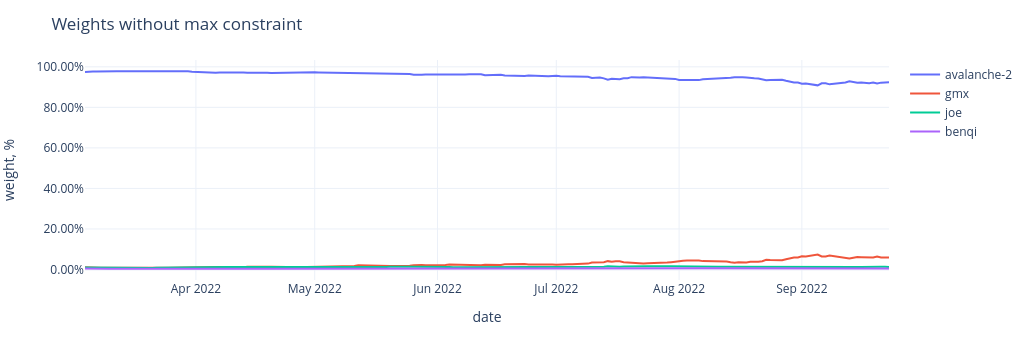

In [137]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

### Adjust weights

This process adjusts weights to adhere to the weight constraints described in our methodology. In addition the `remove_tiny_weights` function checks for any assets with a weight below the minimum threshold of $0.5\%$ and proportionally increases all remaining weights (which are $> 0.5\%$). Note that after this procedure readjusting weights to respect maximum may be needed.

In [138]:
def adjust_weights(weights, max_weight):
    w = weights.copy()
    
    while (w > max_weight).any(axis=None):
        w[w > max_weight] = max_weight
        c = 1 - w.sum(axis=1)
        w_less = w[w < max_weight]
        w[(w < max_weight) & (w > 0)] += w_less.div(w_less.sum(axis=1), axis=0).mul(c, axis=0)
    
    return w

In [139]:
def remove_tiny_weights(weights, min_weight):
    w = weights.copy()
    
    w[w < min_weight] = 0
    w = w.div(w.sum(axis=1), axis=0)
    
    return w

In [140]:
adjusted_weights = adjust_weights(weights, max_weight=0.5) 
adjusted_weights = remove_tiny_weights(adjusted_weights, min_weight=0.005)
adjusted_weights = adjust_weights(adjusted_weights, max_weight=0.5)

adjusted_weights = adjusted_weights.sort_values(adjusted_weights.last_valid_index(),ascending=False, axis = 1)
adjusted_weights

,avalanche-2,gmx,joe,benqi
date,,,,
2022-03-04,0.5,0.218162,0.190478,0.091360
2022-03-05,0.5,0.207803,0.204602,0.087595
2022-03-06,0.5,0.208786,0.202866,0.088348
2022-03-07,0.5,0.200739,0.208059,0.091202
2022-03-08,0.5,0.195796,0.210975,0.093228
...,...,...,...,...
2022-09-19,0.5,0.381690,0.083369,0.034941
2022-09-20,0.5,0.389773,0.077757,0.032471
2022-09-21,0.5,0.380866,0.083616,0.035518


/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



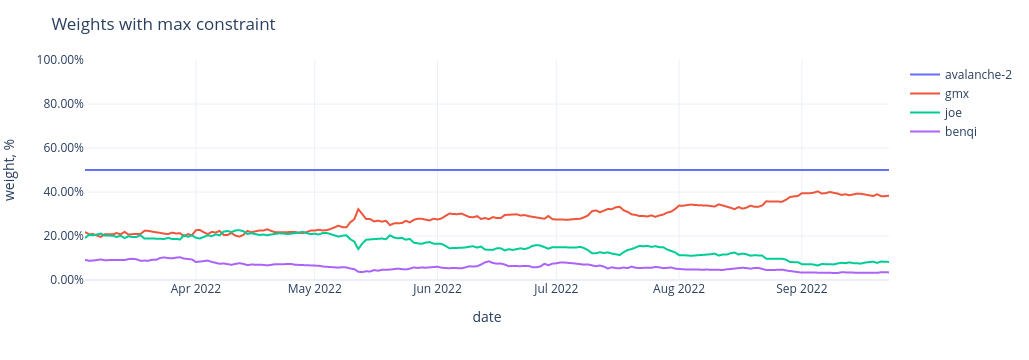

In [141]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
    range=[0,1],
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

### Split AVAX 

In [142]:
if 'avalanche-2' and 'benqi-liquid-staked-avax' in chosen_tokens.index:
    split = 0.2
    adjusted_weights['benqi-liquid-staked-avax'] = adjusted_weights['avalanche-2'] * split
    adjusted_weights['avalanche-2'] = adjusted_weights['avalanche-2'] * (1 - split)


### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [143]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)    
    remainders = w_scaled - w_res    
    k = round(remainders.sum())
    w_below_max = w_res[w_res<128]
    for i in range(k):
        w_below_max[i] +=1
    for i in w_below_max.index:
        w_res[i] = w_below_max[i]
    return w_res

In [144]:
last_weights = adjusted_weights.iloc[-1].dropna()

In [145]:
converted_last_weights = convert_weights(last_weights)

## Summary table

In [146]:
cai = pd.DataFrame()
cai.index = chosen_tokens.index
cai['name'] = chosen_tokens['name']
cai['symbol'] = chosen_tokens['symbol']
cai['market_cap'] = marketcaps.iloc[-1].astype(int)
cai['price'] = prices_data.iloc[-1]
cai['weight'] = last_weights
cai['weight_converted'] = converted_last_weights
cai['address'] = chosen_tokens['addr']

cai = cai[cai['weight'] > 0]
cai = cai.sort_values("market_cap", ascending=False)
cai

,name,symbol,market_cap,price,weight,weight_converted,address
id,,,,,,,
avalanche-2,Avalanche,AVAX,5228726541,17.721192,0.400000,103,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7
gmx,GMX,GMX,331568460,41.146828,0.383283,98,0x62edc0692bd897d2295872a9ffcac5425011c661
benqi-liquid-staked-avax,BENQI Liquid Staked AVAX,SAVAX,87876428,18.346548,0.100000,25,0x2b2c81e08f1af8835a78bb2a90ae924ace0ea4be
joe,JOE,JOE,71028510,0.216813,0.082107,21,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
benqi,BENQI,QI,29940127,0.010168,0.034610,8,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5
